In [1]:
!pip install langgraph langsmith

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install langchain langchain_groq langchain_community

Defaulting to user installation because normal site-packages is not writeable


In [3]:
#<groq and langsmith api keys>

In [4]:
import os

os.environ['LANGSMITH_API_KEY'] = langsmith_api_key
os.environ['LANGCHAIN_TRACING_V2'] = "true"
os.environ['LANGCHAIN_PROJECT'] = "langgraph-chatbot"

In [5]:
import requests

url = "http://127.0.0.1:5000/location"
headers = {'Content-type': 'application/json'}

r = requests.post(url, headers = headers)
loc = r.text
loc

'{"location":["Los Angeles"]}\n'

In [6]:
url = "http://127.0.0.1:5000/crew_desc"
headers = {'Content-type': 'application/json'}

r = requests.post(url, headers = headers)
crew = r.text
crew

'{"end_date":"Fri, 20 Dec 2024 00:00:00 GMT","job_title":"Camera Operator","location":"Los Angeles","project_name":"Project Alpha","skills":"Cinematography, Editing","specializations":"Documentaries","start_date":"Sun, 15 Dec 2024 00:00:00 GMT"}\n'

In [7]:
from langchain_groq import ChatGroq
llm = ChatGroq(groq_api_key = groq_api_key, model_name = "llama-3.1-70b-versatile")

In [8]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

In [9]:
class State(TypedDict):
    messages:Annotated[list, add_messages]

In [10]:
graph_builder = StateGraph(State)

In [11]:
def budget(state: State):
    # Add instructions or description to guide the LLM's response
    system_message = {
        "role": "system",
        "content": f"Generate a comprehensive budget report for the film production. Consider transportation, compliance, logistics, crew, equipment rental, catering, and accommodation costs. Account for hiring costs, including wages and benefits for local and international crew, specifying roles such as directors, cinematographers, and production assistants. If certain crew roles cannot be filled locally, provide cost estimates for flying in specialized personnel. The team is traveling from {loc}."
    }

    # Append the system message to the existing messages in the state
    messages = state.get("messages", [])
    messages.insert(0, system_message)  # Ensure the system message is the first in the conversation

    # Invoke the LLM with the updated messages
    return {"messages": llm.invoke(messages)}

In [12]:
def logistics(state: State):
    # Add instructions or description to guide the LLM's response
    system_message = {
        "role": "system",
        "content": f"Generate a comprehensive report on logistics planning for the shoot. Include travel arrangements, equipment transportation, and the exact details of equipment ordered (e.g., cameras, lights, drones). Analyze where each piece of equipment is currently located, the transportation time required, and contingency plans for delays. Additionally, outline the crew members' travel schedules, current locations, on-site accommodation, and daily transport between locations. The production team is traveling from {loc}."
    }

    # Append the system message to the existing messages in the state
    messages = state.get("messages", [])
    messages.insert(0, system_message)  # Ensure the system message is the first in the conversation

    # Invoke the LLM with the updated messages
    return {"messages": llm.invoke(messages)}

In [13]:
def compliance(state: State):
    # Add instructions or description to guide the LLM's response
    system_message = {
        "role": "system",
        "content": f"Generate a comprehensive compliance checklist for shooting in a foreign location. Include permits, legal requirements, insurance policies, local tax implications, safety protocols, and environmental regulations. If applicable, outline crew-specific compliance requirements, such as work permits, contracts, and union regulations. Provide a timeline for ensuring compliance for both local and international crew members. The production team is traveling from {loc}."
    }

    # Append the system message to the existing messages in the state
    messages = state.get("messages", [])
    messages.insert(0, system_message)  # Ensure the system message is the first in the conversation

    # Invoke the LLM with the updated messages
    return {"messages": llm.invoke(messages)}

In [14]:
def culture(state: State):
    # Add instructions or description to guide the LLM's response
    system_message = {
        "role": "system",
        "content": f"Generate a comprehensive report on cultural considerations for a film shoot. Include local etiquette, communication styles, festivals, potential cultural sensitivities, and how they might impact the shooting schedule. Also, highlight how to best integrate with the local crew, including their work culture and expectations. The production team is traveling from {loc}."
    }

    # Append the system message to the existing messages in the state
    messages = state.get("messages", [])
    messages.insert(0, system_message)  # Ensure the system message is the first in the conversation

    # Invoke the LLM with the updated messages
    return {"messages": llm.invoke(messages)}

In [15]:
def equipment(state: State):
    # Add instructions or description to guide the LLM's response
    system_message = {
        "role": "system",
        "content": f"You are a helpful assistant specializing in providing detailed answers to rental equipments-related queries for film production. Be concise but accurate. Information about the crew: {crew}"
    }

    # Append the system message to the existing messages in the state
    messages = state.get("messages", [])
    messages.insert(0, system_message)  # Ensure the system message is the first in the conversation

    # Invoke the LLM with the updated messages
    return {"messages": llm.invoke(messages)}

In [16]:
def crew(state: State):
    # Add instructions or description to guide the LLM's response
    system_message = {
        "role": "system",
        "content": f"You are a helpful assistant specializing in providing detailed answers to crew-related queries for film production. Be concise but accurate. Information about the crew: {crew}"
    }

    # Append the system message to the existing messages in the state
    messages = state.get("messages", [])
    messages.insert(0, system_message)  # Ensure the system message is the first in the conversation

    # Invoke the LLM with the updated messages
    return {"messages": llm.invoke(messages)}

In [17]:
def continue_next(state: State):
    user_input = state.get('content', '').lower()
    if "culture" in user_input:
        return "culture"
    elif "equipment" in user_input:
        return "equipment"
    else:
        return "crew"

In [18]:
graph_builder.add_node("Budget", budget)
graph_builder.add_node("Logistics", logistics)
graph_builder.add_node("Compliance", compliance)
graph_builder.add_node("Culture", culture)
graph_builder.add_node("Equipment", equipment)
graph_builder.add_node("Crew", crew)

In [19]:
graph_builder.add_conditional_edges(START, continue_next, {"crew": "Crew", "equipment": "Equipment", "culture": "Culture"})

In [20]:
graph_builder.add_edge("Crew", "Logistics")
graph_builder.add_edge("Equipment", "Logistics")
graph_builder.add_edge("Equipment", "Compliance")
graph_builder.add_edge("Logistics", "Budget")
graph_builder.add_edge("Compliance", "Budget")
graph_builder.add_edge("Culture", "Budget")

In [21]:
graph_builder.add_edge("Budget", END)

In [22]:
graph = graph_builder.compile()

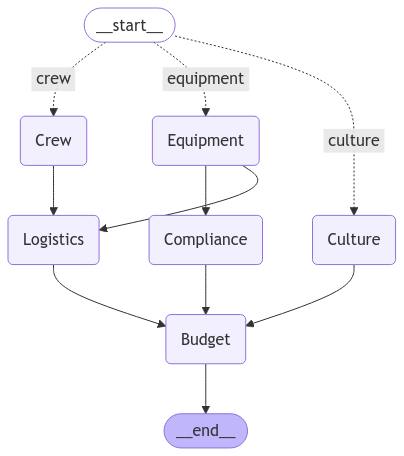

In [23]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)

In [24]:
while True:
    # user is giving an input
    user_input = input("User: ")
    #
    if user_input.lower() == "exit":
        break
    for event in graph.stream({"messages": ("user", user_input)}):
        print(event.values())
        for value in event.values():
            print(value["messages"])
            print("Assistant: ", value["messages"].content)

User: i want to organize a shoot in japan
dict_values([{'messages': AIMessage(content="Organizing a film shoot in Japan can be a unique experience. Here's an overview of what you should consider:\n\n**Permits and Permissions**\n\n1. **Location permits**: Obtain permission from local authorities, such as ward offices or prefectural governments, to film at specific locations.\n2. **National Park permits**: For filming in national parks, you'll need to obtain a permit from the Ministry of the Environment.\n3. **Private property permits**: Get permission from property owners or managers for filming on private land.\n\n**Crew and Staffing**\n\n1. **Local crew**: Hire a Japanese production team, including a line producer, location manager, and camera crew, to help navigate local regulations and customs.\n2. **Language support**: Consider hiring a translator or interpreter to facilitate communication with local authorities, vendors, and crew members.\n\n**Logistics and Equipment**\n\n1. **Equ

### References
<a href="https://www.youtube.com/watch?v=gqvFmK7LpDo">Langgraph introduction video</a> <br>
<a href="https://medium.com/@cplog/introduction-to-langgraph-a-beginners-guide-14f9be027141">Langgraph usage</a> 